In [ ]:
import os
import torch
import pickle
import warnings
import torchaudio
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

# убираем предупреждения
warnings.filterwarnings("ignore", message=".*TorchCodec.*")
warnings.filterwarnings("ignore", message=".*StreamingMediaDecoder.*")

# класс создания общего датасета
class MoodthemeAudioDataset(Dataset):
    def __init__(self, data_dir, labels_dict, mel_spectr_func):
        
        self.data_dir = data_dir
        self.labels_dict = labels_dict
        self.mel_spectr_func = mel_spectr_func

        # множество тегов
        self.moodthemes = set()
        for tags in labels_dict.values():
            self.moodthemes.update(tags)

        # сортриуем и преобразуем теги в индексы
        self.moodthemes = sorted(list(self.moodthemes))
        self.tag_to_idx = {tag: idx for idx, tag in enumerate(self.moodthemes)}
        self.num_classes = len(self.moodthemes)

        # собираем аудиофайлы и теги
        self.audio_files = []
        self.labels = []
        
        for folder_name in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder_name)
            if os.path.isdir(folder_path):
                
                for file_name in os.listdir(folder_path):
                    if self._is_audio_file(file_name):
                        key = os.path.join(folder_name, file_name)
                        if key in labels_dict:
                            full_path = os.path.join(folder_path, file_name)
                            self.audio_files.append(full_path)
                            
                            file_tags = labels_dict[key]
                            multi_hot = self._tags_to_multi_hot(file_tags)
                            self.labels.append(multi_hot)

        self._dummy_mel = self._get_dummy_mel_shape()

    # быстро получает форму мел-спектрограммы
    def _get_dummy_mel_shape(self):
        try:
            dummy_mel = self.mel_spectr_func(self.audio_files[0])
            return dummy_mel.shape
        except:
            return (1, 128, 512) 

    # проверка является ли файл аудиофайлом
    def _is_audio_file(self, filename):
        return filename.lower().endswith(('.wav', '.mp3', '.flac', '.m4a', '.ogg'))
    

    # преобразует список тегов в multi-hot вектор
    def _tags_to_multi_hot(self, tags):
        multi_hot = np.zeros(self.num_classes, dtype=np.float32)
        for tag in tags:
            if tag in self.tag_to_idx:
                multi_hot[self.tag_to_idx[tag]] = 1.0
        return multi_hot


    def get_class_names(self):
        return self.moodthemes
    
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        multi_hot_label = self.labels[idx]
        
        try:
            # вычисляем мел-спектрограмму
            mel_spectrogram = self.mel_spectr_func(audio_path)
            
            # добавляем dimension для канала если нужно
            if len(mel_spectrogram.shape) == 2:
                mel_spectrogram = mel_spectrogram.unsqueeze(0)
            
            # преобразуем метку в тензор
            label_tensor = torch.tensor(multi_hot_label, dtype=torch.float32)
            
            return mel_spectrogram, label_tensor
            
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            # возвращаем тензоры правильной формы
            return torch.zeros(self._dummy_mel), torch.zeros(self.num_classes)
        

def preprocess_audio(audio_path, target_sr = 22050) -> torch.Tensor:
    waveform, sr = torchaudio.load(audio_path, normalize=True, channels_first=True)
    # уменьшил частоту дискретизации, чтобы ещё меньше датасет весил, а то везде 44100 Гц или почти везде
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sr,
        n_mels=128,        
        n_fft=1024,       
        hop_length=256,
        f_min=20,
        f_max=11025
    )(waveform)

    mel_spectrogram = torch.log(mel_spectrogram + 1e-6)

    return mel_spectrogram[0,:,:512]



#------------------------------------------------------------------------------

tags_dict = {}
moodthemes = []

# открываем подготовленный словрь
with open("../data/track_tags.pkl", 'rb') as file:
    tags_dict = pickle.load(file)

# список тегов
for tags in tags_dict.values():
    for tag in tags:
        if tag not in moodthemes:
            moodthemes.append(tag)

# создаём датасет
dataset = MoodthemeAudioDataset(
    data_dir = "../data/train",
    labels_dict = tags_dict,
    mel_spectr_func = preprocess_audio
)

# разбиваем датасет на train и test
dataset_size = len(dataset)
indices = list(range(dataset_size))

train_idx, test_idx = train_test_split(
    indices, 
    test_size = 0.15,
    train_size = 0.85,       
    random_state = 42        # для воспроизводимости
)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size = 64,
    shuffle = True,
    num_workers = 12,
    pin_memory = True,
    persistent_workers = True,
    prefetch_factor = 2,
    drop_last = True
)

test_loader = DataLoader(
    test_dataset,
    batch_size = 64,
    shuffle = False,
    num_workers = 12,
    pin_memory = True,
    persistent_workers = True,
    prefetch_factor = 2,
    drop_last = True
)

# тут будут классы моделей
class SimpleFCModel(nn.Module):
    def __init__(self, num_classes: int, input_height: int, input_width: int, hidden_size: int):
        super(SimpleFCModel, self).__init__()
        
        self.input_height = input_height
        self.input_width = input_width
        self.num_classes = num_classes
        
        # Вычисляем размер после вытягивания в вектор
        self.flatten_size = input_height * input_width
        
        self.layers = nn.Sequential(
            # Вытягиваем в плоский вектор
            nn.Flatten(),
            
            # Первый скрытый слой
            nn.Linear(self.flatten_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.25),  # для регуляризации
            
            # Второй скрытый слой (можно добавить больше)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(), 
            nn.Dropout(0.25),
            
            # Выходной слой
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        return self.layers(x)

In [56]:
from tqdm import tqdm
from sklearn.metrics import f1_score

def train_epoch(model, loader, optimizer, criterion, device):
    """
    Простая функция обучения для мультитеговой классификации аудио
    """
    model.train()
    running_loss = 0.0
    all_targets = []
    all_predictions = []
    
    pbar = tqdm(loader, desc='Training')
    
    for data, targets in pbar:
        
        data = data.to(device)                          # 
        targets = targets.to(device)                    # Перемещаем данные на устройство
        
        optimizer.zero_grad()                           # Обнуляем градиенты
        
        outputs = model(data)                           # Прямой проход
        
        loss = criterion(outputs, targets)              # Вычисляем loss
        
        loss.backward()                                 # 
        optimizer.step()                                # Обратный проход
        
        with torch.no_grad():                           # 
            probs = torch.sigmoid(outputs)              #
            predictions = (probs > 0.5).float()         # Сохраняем предсказания и цели для метрик
                                                        #
            all_targets.append(targets.cpu())           #
            all_predictions.append(predictions.cpu())   #
        
        running_loss += loss.item()                     # Обновляем статистику
        
        # Обновляем прогресс-бар
        current_loss = running_loss / len(loader)       
        pbar.set_postfix({'Loss': f'{current_loss:.4f}'})
    
    # Вычисляем метрики
    all_targets = torch.cat(all_targets)
    all_predictions = torch.cat(all_predictions)
    
    # Accuracy
    accuracy = (all_predictions == all_targets).float().mean().item()
    
    # F1-score (macro)
    f1 = f1_score(all_targets.numpy(), all_predictions.numpy(), average='macro', zero_division=0)
    
    epoch_loss = running_loss / len(loader)
    
    return {
        'loss': epoch_loss,
        'accuracy': accuracy,
        'f1': f1
    }


def evaluate_epoch(model, loader, criterion, device):
    """
    Функция оценки для мультитеговой классификации аудио
    """
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []
    all_probs = []
    
    pbar = tqdm(loader, desc='Evaluation')
    
    with torch.no_grad():
        for data, targets in pbar:
            data = data.to(device)                      #
            targets = targets.to(device)                # Перемещаем данные на устройство
            
            outputs = model(data)                       # Прямой проход
            
            loss = criterion(outputs, targets)          # Вычисляем loss
            
            probs = torch.sigmoid(outputs)              # 
            predictions = (probs > 0.5).float()         # Получаем вероятности и предсказания

            all_targets.append(targets.cpu())           # 
            all_predictions.append(predictions.cpu())   #
            all_probs.append(probs.cpu())               # Сохраняем для метрик
            
            running_loss += loss.item()                 # Обновляем статистику
            
            # Обновляем прогресс-бар
            current_loss = running_loss / len(loader)
            pbar.set_postfix({'Loss': f'{current_loss:.4f}'})
    
    # Объединяем все батчи
    all_targets = torch.cat(all_targets)
    all_predictions = torch.cat(all_predictions)
    all_probs = torch.cat(all_probs)
    
    # Вычисляем метрики
    accuracy = (all_predictions == all_targets).float().mean().item()
    f1 = f1_score(all_targets.numpy(), all_predictions.numpy(), average='macro', zero_division=0)
    epoch_loss = running_loss / len(loader)
    
    return {
        'loss': epoch_loss,
        'accuracy': accuracy,
        'f1': f1,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probs
    }

def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, save_dir='../data/models'):
    # Создаем директорию для сохранения
    os.makedirs(save_dir, exist_ok=True)
    
    # Инициализируем лучшие метрики
    best_f1 = 0.0
    best_epoch = 0
    
    # История обучения
    history = {
        'train_loss': [], 'train_accuracy': [], 'train_f1': [],
        'val_loss': [], 'val_accuracy': [], 'val_f1': []
    }
    
    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        print('-' * 50)
        
        # Обучение
        train_metrics = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Валидация
        val_metrics = evaluate_epoch(model, val_loader, criterion, device)
        
        # Сохраняем историю
        history['train_loss'].append(train_metrics['loss'])
        history['train_accuracy'].append(train_metrics['accuracy'])
        history['train_f1'].append(train_metrics['f1'])
        history['val_loss'].append(val_metrics['loss'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        
        # Выводим метрики
        print(f'Train - Loss: {train_metrics["loss"]:.4f}, Acc: {train_metrics["accuracy"]:.4f}, F1: {train_metrics["f1"]:.4f}')
        print(f'Val   - Loss: {val_metrics["loss"]:.4f}, Acc: {val_metrics["accuracy"]:.4f}, F1: {val_metrics["f1"]:.4f}')
        
        # Сохраняем лучшую модель
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_epoch = epoch
            
            # Сохраняем модель
            best_model_path = os.path.join(save_dir, 'FCmodel_best.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': best_f1,
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['accuracy']
            }, best_model_path)
            print(f'✓ New best model saved! F1: {best_f1:.4f}')
        
        # Сохраняем бэкап каждые 5 эпох
        if epoch % 5 == 0:
            backup_path = os.path.join(save_dir, f'FCmodel_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': best_f1,
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['accuracy']
            }, backup_path)
            print(f'✓ Backup saved: {backup_path}')
    
    print(f'\nTraining completed!')
    print(f'Best model: epoch {best_epoch}, F1: {best_f1:.4f}')
    
    return history, best_f1

def load_model(model, checkpoint_path, optimizer=None, device=None, verbose=True):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Загружаем веса модели
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Загружаем оптимизатор если нужно
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # Переносим состояние оптимизатора на правильное устройство
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
    
    if verbose:
        print(f'Model loaded from {checkpoint_path}')
        print(f'Epoch: {checkpoint["epoch"]}')
        val_f1 = checkpoint.get('val_f1', 'N/A')
        print(f'Val F1: {val_f1}')
    
    return model

def plot_history(history, figsize=(15, 10)):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Создаем subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Training History', fontsize=16, fontweight='bold')
    
    # 1. График Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. График Accuracy
    axes[0, 1].plot(epochs, history['train_accuracy'], 'b-', label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2)
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 1)
    
    # 3. График F1-score
    axes[1, 0].plot(epochs, history['train_f1'], 'b-', label='Train F1', linewidth=2)
    axes[1, 0].plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2)
    axes[1, 0].set_title('F1-Score (Macro)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1-Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim(0, 1)
    
    # 4. Сводный график всех метрик (валидация) - ИСПРАВЛЕННАЯ ЧАСТЬ
    axes[1, 1].plot(epochs, history['val_accuracy'], 'g-', label='Val Accuracy', linewidth=2)
    axes[1, 1].plot(epochs, history['val_f1'], 'orange', label='Val F1', linewidth=2)
    
    # ИСПРАВЛЕНИЕ: преобразуем в numpy array перед делением
    val_loss = np.array(history['val_loss'])
    if max(val_loss) > 0:  # Проверяем чтобы не делить на 0
        val_loss_norm = val_loss / max(val_loss)
    else:
        val_loss_norm = val_loss
    
    axes[1, 1].plot(epochs, val_loss_norm, 'r-', label='Val Loss (norm)', linewidth=2)
    axes[1, 1].set_title('Validation Metrics Summary')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Выводим лучшие значения
    best_val_acc = max(history['val_accuracy'])
    best_val_f1 = max(history['val_f1'])
    best_epoch_acc = history['val_accuracy'].index(best_val_acc) + 1
    best_epoch_f1 = history['val_f1'].index(best_val_f1) + 1
    
    print("Training Results Summary:")
    print(f"Best Validation Accuracy: {best_val_acc:.4f} (epoch {best_epoch_acc})")
    print(f"Best Validation F1-Score: {best_val_f1:.4f} (epoch {best_epoch_f1})")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Final Train Accuracy: {history['train_accuracy'][-1]:.4f}")
    print(f"Final Train F1: {history['train_f1'][-1]:.4f}")

Используется устройство: cuda

Epoch 1/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it, Loss=0.3504]


Train - Loss: 0.6412, Acc: 0.7057, F1: 0.0469
Val   - Loss: 0.3504, Acc: 0.9098, F1: 0.0235
✓ New best model saved! F1: 0.0235

Epoch 2/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it, Loss=0.2078]


Train - Loss: 0.4026, Acc: 0.8359, F1: 0.0418
Val   - Loss: 0.2078, Acc: 0.9614, F1: 0.0056

Epoch 3/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it, Loss=0.1722]


Train - Loss: 0.2922, Acc: 0.9016, F1: 0.0455
Val   - Loss: 0.1722, Acc: 0.9669, F1: 0.0026

Epoch 4/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it, Loss=0.1570]


Train - Loss: 0.2364, Acc: 0.9316, F1: 0.0402
Val   - Loss: 0.1570, Acc: 0.9680, F1: 0.0000

Epoch 5/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1528]


Train - Loss: 0.2081, Acc: 0.9451, F1: 0.0357
Val   - Loss: 0.1528, Acc: 0.9683, F1: 0.0015
✓ Backup saved: ../data/models/FCmodel_5.pth

Epoch 6/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it, Loss=0.1477]


Train - Loss: 0.1897, Acc: 0.9526, F1: 0.0265
Val   - Loss: 0.1477, Acc: 0.9696, F1: 0.0000

Epoch 7/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1484]


Train - Loss: 0.1784, Acc: 0.9578, F1: 0.0291
Val   - Loss: 0.1484, Acc: 0.9699, F1: 0.0000

Epoch 8/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it, Loss=0.1485]


Train - Loss: 0.1707, Acc: 0.9596, F1: 0.0313
Val   - Loss: 0.1485, Acc: 0.9696, F1: 0.0000

Epoch 9/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1446]


Train - Loss: 0.1663, Acc: 0.9621, F1: 0.0252
Val   - Loss: 0.1446, Acc: 0.9699, F1: 0.0015

Epoch 10/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it, Loss=0.1451]


Train - Loss: 0.1565, Acc: 0.9643, F1: 0.0308
Val   - Loss: 0.1451, Acc: 0.9698, F1: 0.0000
✓ Backup saved: ../data/models/FCmodel_10.pth

Epoch 11/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1440]


Train - Loss: 0.1513, Acc: 0.9649, F1: 0.0324
Val   - Loss: 0.1440, Acc: 0.9699, F1: 0.0000

Epoch 12/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it, Loss=0.1444]


Train - Loss: 0.1478, Acc: 0.9655, F1: 0.0363
Val   - Loss: 0.1444, Acc: 0.9699, F1: 0.0000

Epoch 13/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it, Loss=0.1438]


Train - Loss: 0.1463, Acc: 0.9662, F1: 0.0282
Val   - Loss: 0.1438, Acc: 0.9697, F1: 0.0000

Epoch 14/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it, Loss=0.1464]


Train - Loss: 0.1451, Acc: 0.9663, F1: 0.0337
Val   - Loss: 0.1464, Acc: 0.9697, F1: 0.0000

Epoch 15/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1410]


Train - Loss: 0.1392, Acc: 0.9671, F1: 0.0333
Val   - Loss: 0.1410, Acc: 0.9699, F1: 0.0000
✓ Backup saved: ../data/models/FCmodel_15.pth

Epoch 16/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1414]


Train - Loss: 0.1363, Acc: 0.9674, F1: 0.0317
Val   - Loss: 0.1414, Acc: 0.9698, F1: 0.0000

Epoch 17/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it, Loss=0.1412]


Train - Loss: 0.1313, Acc: 0.9679, F1: 0.0433
Val   - Loss: 0.1412, Acc: 0.9698, F1: 0.0000

Epoch 18/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1426]


Train - Loss: 0.1299, Acc: 0.9680, F1: 0.0376
Val   - Loss: 0.1426, Acc: 0.9698, F1: 0.0000

Epoch 19/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it, Loss=0.1448]


Train - Loss: 0.1290, Acc: 0.9680, F1: 0.0516
Val   - Loss: 0.1448, Acc: 0.9697, F1: 0.0000

Epoch 20/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1423]


Train - Loss: 0.1281, Acc: 0.9683, F1: 0.0516
Val   - Loss: 0.1423, Acc: 0.9697, F1: 0.0000
✓ Backup saved: ../data/models/FCmodel_20.pth

Epoch 21/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it, Loss=0.1460]


Train - Loss: 0.1256, Acc: 0.9682, F1: 0.0538
Val   - Loss: 0.1460, Acc: 0.9698, F1: 0.0000

Epoch 22/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1443]


Train - Loss: 0.1227, Acc: 0.9687, F1: 0.0517
Val   - Loss: 0.1443, Acc: 0.9697, F1: 0.0000

Epoch 23/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1434]


Train - Loss: 0.1186, Acc: 0.9692, F1: 0.0571
Val   - Loss: 0.1434, Acc: 0.9696, F1: 0.0010

Epoch 24/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1470]


Train - Loss: 0.1191, Acc: 0.9690, F1: 0.0561
Val   - Loss: 0.1470, Acc: 0.9697, F1: 0.0014

Epoch 25/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it, Loss=0.1456]


Train - Loss: 0.1180, Acc: 0.9690, F1: 0.0682
Val   - Loss: 0.1456, Acc: 0.9698, F1: 0.0014
✓ Backup saved: ../data/models/FCmodel_25.pth

Epoch 26/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1428]


Train - Loss: 0.1146, Acc: 0.9695, F1: 0.0836
Val   - Loss: 0.1428, Acc: 0.9698, F1: 0.0000

Epoch 27/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1433]


Train - Loss: 0.1132, Acc: 0.9695, F1: 0.0714
Val   - Loss: 0.1433, Acc: 0.9698, F1: 0.0014

Epoch 28/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1442]


Train - Loss: 0.1124, Acc: 0.9701, F1: 0.0968
Val   - Loss: 0.1442, Acc: 0.9698, F1: 0.0000

Epoch 29/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it, Loss=0.1463]


Train - Loss: 0.1102, Acc: 0.9695, F1: 0.0900
Val   - Loss: 0.1463, Acc: 0.9697, F1: 0.0014

Epoch 30/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it, Loss=0.1476]


Train - Loss: 0.1092, Acc: 0.9701, F1: 0.1041
Val   - Loss: 0.1476, Acc: 0.9698, F1: 0.0000
✓ Backup saved: ../data/models/FCmodel_30.pth

Epoch 31/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1451]


Train - Loss: 0.1078, Acc: 0.9704, F1: 0.1066
Val   - Loss: 0.1451, Acc: 0.9696, F1: 0.0015

Epoch 32/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it, Loss=0.1425]


Train - Loss: 0.1047, Acc: 0.9707, F1: 0.1256
Val   - Loss: 0.1425, Acc: 0.9698, F1: 0.0000

Epoch 33/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it, Loss=0.1478]


Train - Loss: 0.1039, Acc: 0.9706, F1: 0.1167
Val   - Loss: 0.1478, Acc: 0.9698, F1: 0.0015

Epoch 34/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it, Loss=0.1438]


Train - Loss: 0.1012, Acc: 0.9710, F1: 0.1425
Val   - Loss: 0.1438, Acc: 0.9698, F1: 0.0014

Epoch 35/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it, Loss=0.1454]


Train - Loss: 0.1030, Acc: 0.9710, F1: 0.1404
Val   - Loss: 0.1454, Acc: 0.9697, F1: 0.0000
✓ Backup saved: ../data/models/FCmodel_35.pth

Epoch 36/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1479]


Train - Loss: 0.0997, Acc: 0.9712, F1: 0.1547
Val   - Loss: 0.1479, Acc: 0.9697, F1: 0.0015

Epoch 37/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it, Loss=0.1445]


Train - Loss: 0.0989, Acc: 0.9714, F1: 0.1602
Val   - Loss: 0.1445, Acc: 0.9695, F1: 0.0015

Epoch 38/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1512]


Train - Loss: 0.0968, Acc: 0.9717, F1: 0.1898
Val   - Loss: 0.1512, Acc: 0.9698, F1: 0.0015

Epoch 39/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it, Loss=0.1460]


Train - Loss: 0.0974, Acc: 0.9719, F1: 0.1804
Val   - Loss: 0.1460, Acc: 0.9693, F1: 0.0023

Epoch 40/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1503]


Train - Loss: 0.0932, Acc: 0.9718, F1: 0.1782
Val   - Loss: 0.1503, Acc: 0.9694, F1: 0.0039
✓ Backup saved: ../data/models/FCmodel_40.pth

Epoch 41/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it, Loss=0.1474]


Train - Loss: 0.0900, Acc: 0.9727, F1: 0.2171
Val   - Loss: 0.1474, Acc: 0.9693, F1: 0.0032

Epoch 42/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it, Loss=0.1505]


Train - Loss: 0.0895, Acc: 0.9726, F1: 0.2018
Val   - Loss: 0.1505, Acc: 0.9698, F1: 0.0036

Epoch 43/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it, Loss=0.1500]


Train - Loss: 0.0893, Acc: 0.9730, F1: 0.2149
Val   - Loss: 0.1500, Acc: 0.9695, F1: 0.0043

Epoch 44/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1492]


Train - Loss: 0.0896, Acc: 0.9724, F1: 0.2120
Val   - Loss: 0.1492, Acc: 0.9697, F1: 0.0026

Epoch 45/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it, Loss=0.1522]


Train - Loss: 0.0898, Acc: 0.9729, F1: 0.2379
Val   - Loss: 0.1522, Acc: 0.9698, F1: 0.0026
✓ Backup saved: ../data/models/FCmodel_45.pth

Epoch 46/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1534]


Train - Loss: 0.0858, Acc: 0.9739, F1: 0.2560
Val   - Loss: 0.1534, Acc: 0.9695, F1: 0.0051

Epoch 47/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it, Loss=0.1574]


Train - Loss: 0.0845, Acc: 0.9735, F1: 0.2562
Val   - Loss: 0.1574, Acc: 0.9696, F1: 0.0000

Epoch 48/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it, Loss=0.1569]


Train - Loss: 0.0841, Acc: 0.9740, F1: 0.2709
Val   - Loss: 0.1569, Acc: 0.9689, F1: 0.0044

Epoch 49/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it, Loss=0.1551]


Train - Loss: 0.0853, Acc: 0.9732, F1: 0.2605
Val   - Loss: 0.1551, Acc: 0.9697, F1: 0.0122

Epoch 50/50
--------------------------------------------------


Evaluation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it, Loss=0.1548]


Train - Loss: 0.0835, Acc: 0.9737, F1: 0.2755
Val   - Loss: 0.1548, Acc: 0.9688, F1: 0.0023
✓ Backup saved: ../data/models/FCmodel_50.pth

Training completed!
Best model: epoch 1, F1: 0.0235


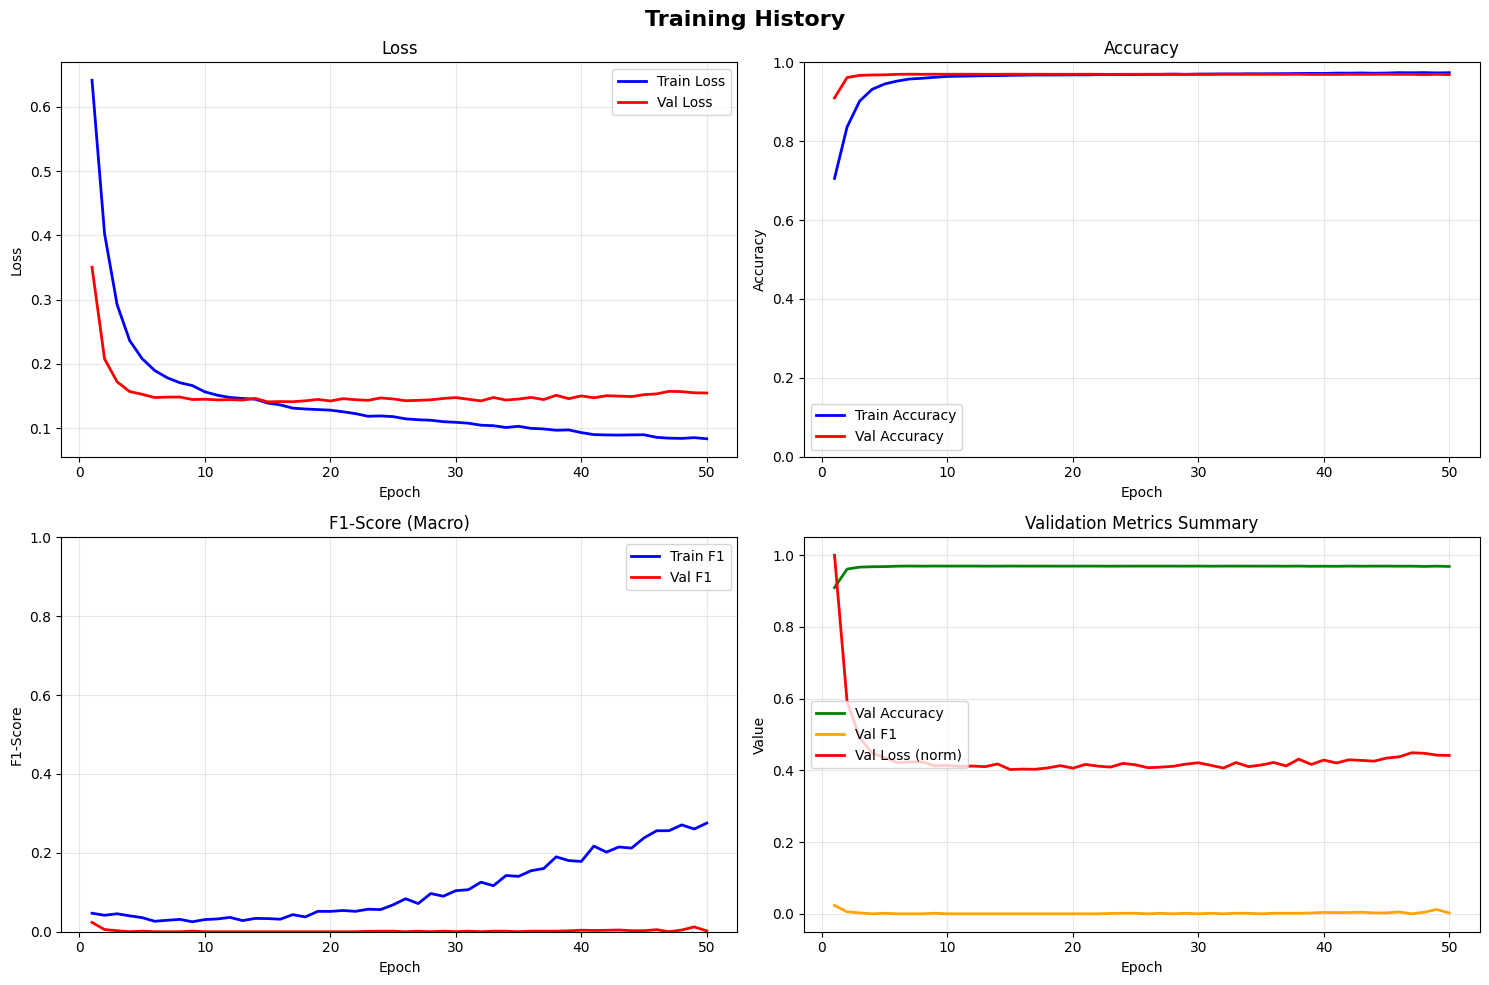

Training Results Summary:
Best Validation Accuracy: 0.9699 (epoch 7)
Best Validation F1-Score: 0.0235 (epoch 1)
Final Validation Loss: 0.1548
Final Train Accuracy: 0.9737
Final Train F1: 0.2755


In [57]:
# Инициализация модели
model = SimpleFCModel(
    num_classes=len(dataset.get_class_names()),
    input_height=128,
    input_width=512,
    hidden_size=256
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Используется устройство: {device}")

# Загрузка модели с указанием устройства
# model = load_model(
#     model=model,
#     checkpoint_path="../data/models/FCmodel_5.pth",
#     optimizer=optimizer,
#     device=device
# )

# Переносим модел на устройство
model.to(device)

# Запуск обучения
history, best_f1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=50,
    save_dir='../data/models'
)

# вывод графиков
plot_history(history)

In [59]:
def quick_predict(model, audio_path, preprocess_function, class_names, device='cuda', treshold = 0.5):
    # Убедимся, что модель на правильном устройстве
    model.to(device)
    model.eval()
    
    try:
        # Препроцессинг
        mel_spec = preprocess_function(audio_path)
        
        # Добавляем batch dimension и перемещаем на устройство
        if len(mel_spec.shape) == 3:  # [channels, height, width]
            input_tensor = mel_spec.unsqueeze(0)  # [1, channels, height, width]
        else:
            input_tensor = mel_spec.unsqueeze(0).unsqueeze(0)  # [1, 1, height, width]
        
        input_tensor = input_tensor.to(device)
        
        # Предсказание
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.sigmoid(outputs).cpu().numpy()[0]
        
        # Результаты
        print(f"\n Prediction for: {os.path.basename(audio_path)}")
        
        active_tags = []
        for i, (class_name, prob) in enumerate(zip(class_names, probs)):
            if prob > treshold:
                print(f"  -- {class_name}: {prob:.3f}")
                active_tags.append(class_name)
        
        if not active_tags:
            print(f" No tags predicted above 0.5 threshold")
            
        return probs, active_tags
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

best_model = SimpleFCModel(
    input_height=128,        
    input_width=512,          
    hidden_size=256,  
    num_classes=len(dataset.get_class_names()),             
)

load_model(best_model, '../data/models/FCmodel_50.pth')
best_model.to(device)
best_model.eval()

test_audio_path = "../data/train/00/16000.mp3"

quick_predict(
    model=model,
    audio_path=test_audio_path,
    preprocess_function=preprocess_audio,
    class_names=dataset.get_class_names(),
    device=device,
    treshold = 0.2
)

Model loaded from ../data/models/FCmodel_50.pth
Epoch: 50
Val F1: 0.02349860960088265

 Prediction for: 16000.mp3
  -- powerful: 0.368


(array([7.75232241e-02, 1.52815636e-02, 1.86330604e-03, 2.11814209e-03,
        3.42407562e-02, 6.92454353e-03, 3.46100843e-03, 3.68394860e-04,
        5.12269093e-03, 3.71829694e-04, 1.18710008e-02, 9.60402284e-03,
        1.28517160e-02, 4.10451256e-02, 3.23862914e-04, 2.33257115e-02,
        5.43466657e-02, 1.62980543e-03, 1.25186145e-02, 7.75945485e-02,
        1.24869004e-01, 1.65016893e-02, 7.97062181e-04, 8.79089255e-03,
        1.89947244e-02, 4.25714534e-03, 2.16921568e-02, 2.92612799e-02,
        8.21113680e-03, 3.21777188e-03, 2.43930728e-04, 1.60932657e-03,
        4.57313115e-04, 8.68559908e-03, 1.95495784e-03, 4.25197557e-03,
        2.60328059e-03, 2.50104014e-02, 9.29270609e-05, 1.67136732e-02,
        2.71868259e-02, 7.33272312e-03, 2.54293904e-02, 3.67539942e-01,
        1.65359285e-02, 9.55489697e-04, 1.06098654e-03, 1.31435245e-02,
        8.08679219e-03, 3.00727808e-03, 4.02861312e-02, 2.70326063e-02,
        1.58722047e-02, 1.20344087e-02, 8.10370371e-02, 2.166840